In [14]:
import cv2
import numpy as np
import fingerprint_enhancer
import matplotlib.pyplot as plt
import os
import random

In [15]:
# Set dataset folder path
dataset_path = "./ab"

In [16]:
# List all image files
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.bmp', '.jpg', '.png', '.jpeg'))]

In [17]:
# Select a few images for visualization
sample_images = random.sample(image_files, min(5, len(image_files)))

Define Noise Reduction Function (Gaussian Blur and Thresholding)

In [18]:
def noise_reduction(image):
    """Apply Gaussian blur followed by adaptive thresholding."""
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)

    # Apply adaptive thresholding
    threshold_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 5)
    
    return threshold_image


Define Data Augmentation Function

In [19]:
def augment_image(image):
    """Apply augmentation: rotation, flipping, and resizing."""
    augmented_images = []

    # Ensure image is uint8
    image = (image * 255).astype(np.uint8)

    # Rotate (random angles)
    for angle in [15, -15, 30, -30]:
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h))
        augmented_images.append(rotated)
    
    # Flip (Horizontal and Vertical)
    flipped_horizontally = cv2.flip(image, 1)  # Horizontal flip
    augmented_images.append(flipped_horizontally)
    
    flipped_vertically = cv2.flip(image, 0)  # Vertical flip
    augmented_images.append(flipped_vertically)


    return augmented_images

Lets apply masked processing to apply noise reduction  only to the fingerprint and leave the white space

In [20]:
def apply_masked_processing(image):
    """Apply processing only to the fingerprint region."""
    # Step 1: Create a binary mask for the fingerprint region
    _, binary_mask = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)
    
    # Step 2: Apply Gaussian blur to the entire image
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
    
    # Step 3: Apply adaptive thresholding to the blurred image
    threshold_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 5)
    
    # Step 4: Isolate the fingerprint area (where mask is white)
    enhanced_fingerprint = cv2.bitwise_and(threshold_image, threshold_image, mask=binary_mask)
    
    # Step 5: Keep the original background (where mask is black)
    background = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(binary_mask))
    
    # Step 6: Combine the enhanced fingerprint and the original background
    final_image = cv2.add(enhanced_fingerprint, background)
    
    return final_image

Now we apply those funtions  ot sample images  and shwo for comparison

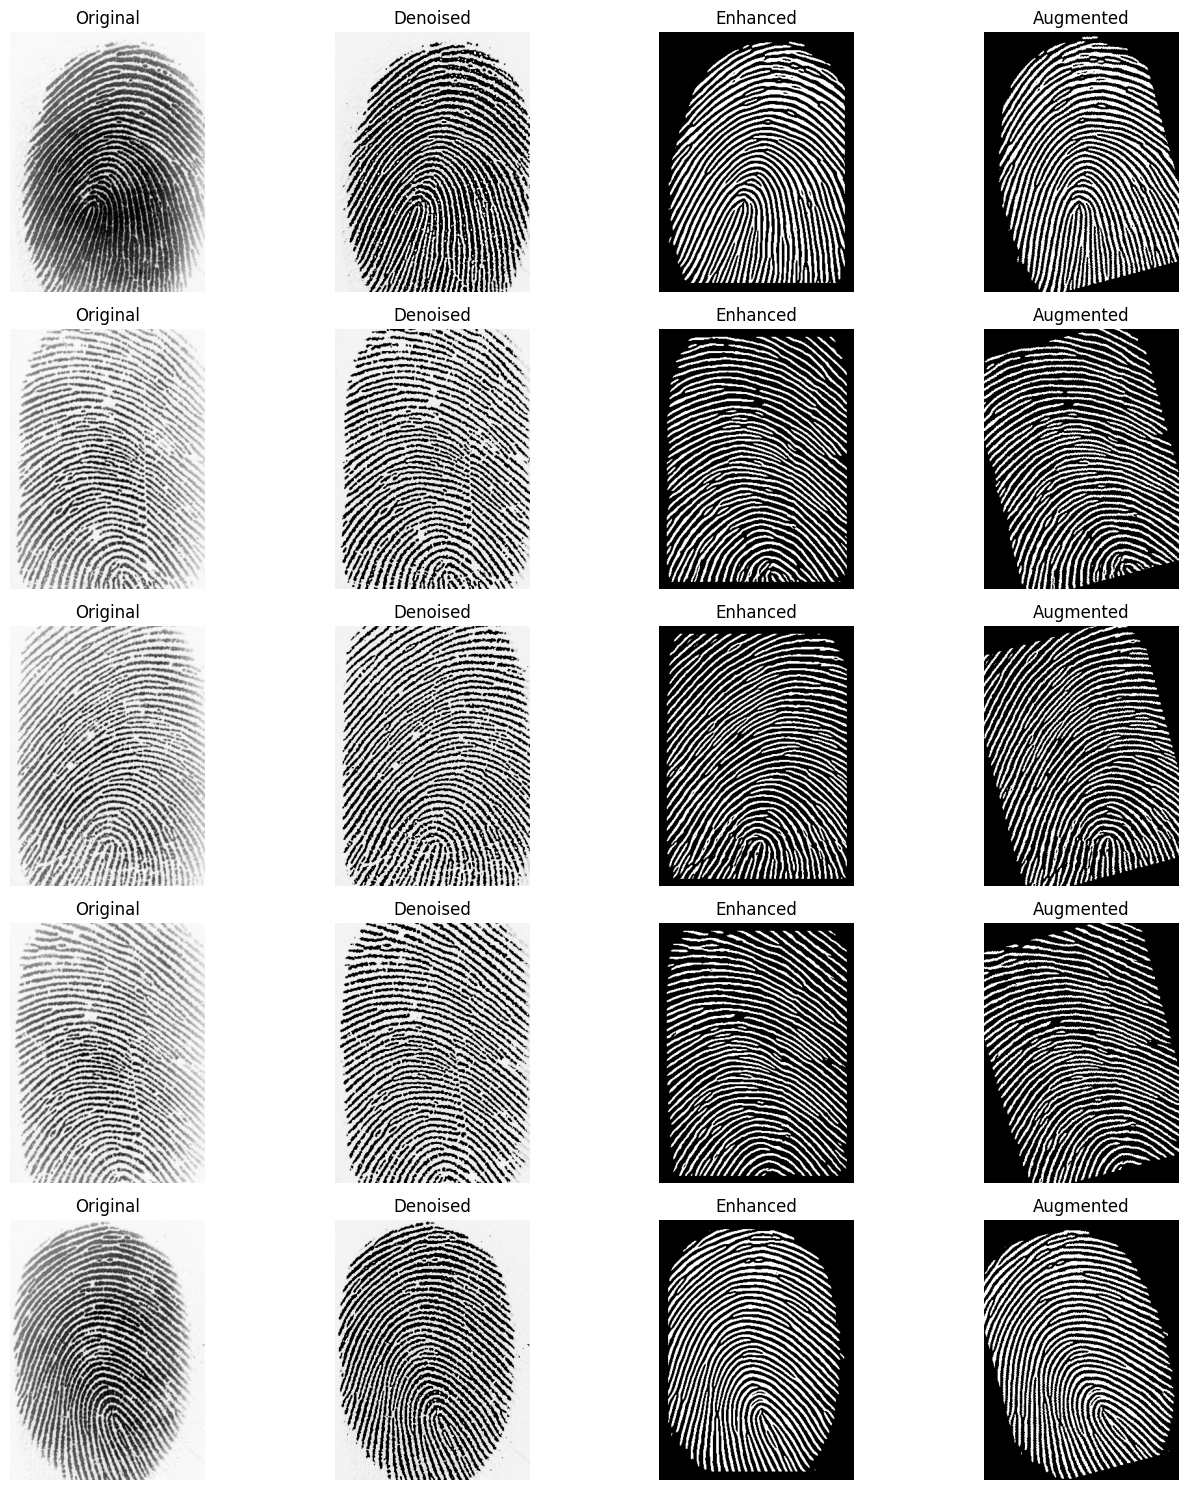

In [21]:

# Plot original, denoised, enhanced, and augmented images
fig, axes = plt.subplots(len(sample_images), 4, figsize=(14, 15))

for i, img_name in enumerate(sample_images):
    # Load image
    img_path = os.path.join(dataset_path, img_name)
    img = cv2.imread(img_path, 0)

    # Apply masked noise reduction and enhancement
    denoised_img = apply_masked_processing(img)

    # Enhance fingerprint
    enhanced_img = fingerprint_enhancer.enhance_fingerprint(denoised_img)
    enhanced_img = (enhanced_img * 255).astype(np.uint8)  # Convert to uint8

    # Apply augmentation
    augmented_imgs = augment_image(enhanced_img)

    # Display original
    axes[i, 0].imshow(img, cmap="gray")
    axes[i, 0].set_title("Original")

    # Display denoised (processed with mask)
    axes[i, 1].imshow(denoised_img, cmap="gray")
    axes[i, 1].set_title("Denoised")

    # Display enhanced
    axes[i, 2].imshow(enhanced_img, cmap="gray")
    axes[i, 2].set_title("Enhanced")

    # Display one augmented sample
    axes[i, 3].imshow(augmented_imgs[0], cmap="gray")
    axes[i, 3].set_title("Augmented")


    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()